# Olist Sales Prediction

Olist was founded in 2015 and was relatively new business when they released their dataset on Kaggel. We have observations from Sept 2016 to Aug 2018. 
For a relatively new business it is very critical to understand how their business is growing and how they can be prepared to scale and maintain it further.

Keeping this in mind, we are trying to forecast the sales for Olist so that they can channelize their resources for stock preparation, marketing campaigns and get better prepared for future.

# Index

[1. Importing Libraries](#Importing_libraries) </br>
[2. Importing Data](#Importing_Data)</br>
[2.1 Data dictionary](#Data_dictionary) </br>
[2.2 Processing data for time series](#Processing_data_for_time_series) </br>
[3. Explorartory Data Analysis](#Explorartory_Data_Analysis)</br>
[3.1 General exploration](#General_exploration) </br>
[3.2 Decomposing time series](#Decomposing_time_series) </br>
[3.3 Checking stationarity](#Checking_stationarity) </br>
[4. Preparation for Modeling](#Preparation_for_Modeling)</br>
[4.1 Train and test split](#Train_test_split) </br>
[4.2 Defining functions for plotting predictions and forecast](#plotting_func) </br>
[4.3 Defining functions for evaluation](#evaluation_metrics) </br>
[5. Modelling (SARIMA)](#SARIMA) </br>
[5.1 Plotting ACF and PACF plot](#ACF_PACF) </br>
[5.2 Applying SARIMA model](#Baseline) </br>
[5.3 Plotting predictions and evaluating SARIMA model](#plot)</br>
[6. Modelling (FB Prophet)](#FB_Prophet) </br>
[6.1 Preparing data for FB Prophet](#fb_prep) </br>
[6.2 Applying a Baseline FB Prophet](#fb_baseline) </br>
[6.3 Plotting and Evaluating Baseline model](#fb_plot) </br>
[7. Discussing issues encounted with hourly sampled data](#discussion) </br>
[8. Conclusion](#conclusion)

# 1. Importing Libraries

<a id="Importing_libraries"></a>

In [79]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= 'darkgrid' )

#some built in functions
import itertools
from datetime import datetime, timedelta

import warnings
#to supress warning generated for fb prophet using .append method by default
# warnings.simplefilter(action='ignore', category=FutureWarning) 
#to suppress warnings in Sarima model
# warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

#importing high level interactive plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#importing Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

#sklearn library
from sklearn.preprocessing import MinMaxScaler

#importing fb prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly

#importing XG Boost 
import xgboost as xgb
from xgboost import plot_importance, plot_tree

#importing LSTM libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [80]:
import plotly.io as pio
pio.renderers.default= "svg"

#had to install orca to publish static images of plotly graph on git hub as plotly plots were not showing up.
# installed using conda install -c plotly plotly-orca and had to manually assign the path to orca exe.

# 2. Importing Data

<a id="Importing_Data"></a>

In [81]:
#loading the dataset
master=pd.read_csv('data_cleaned/master_dataset.csv')

In [82]:
#reading the head
master.head()

,order_id,customer_id,order_purchase_timestamp,order_estimated_delivery_date,qty,product_id,seller_id,shipping_limit_date,price,freight_value,...,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,customer_lat,customer_lng,review_score,total_amount
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,...,SP,-23.680862,-46.444311,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,-23.577482,-46.587077,4,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,...,SP,-19.807885,-43.980818,af07308b275d755c9edb36a90c618231,barreiras,BA,-12.186877,-44.540232,4,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,...,SP,-21.363473,-48.229588,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,-16.745150,-48.514783,5,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,...,MG,-19.836871,-43.923241,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN,-5.774002,-35.270976,5,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,...,SP,-23.541525,-46.262148,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP,-23.676257,-46.514580,5,19.90


In [83]:
#understanding the datatypes
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110013 entries, 0 to 110012
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110013 non-null  object 
 1   customer_id                    110013 non-null  object 
 2   order_purchase_timestamp       110013 non-null  object 
 3   order_estimated_delivery_date  110013 non-null  object 
 4   qty                            110013 non-null  int64  
 5   product_id                     110013 non-null  object 
 6   seller_id                      110013 non-null  object 
 7   shipping_limit_date            110013 non-null  object 
 8   price                          110013 non-null  float64
 9   freight_value                  110013 non-null  float64
 10  product_name_lenght            110013 non-null  float64
 11  product_description_lenght     110013 non-null  float64
 12  product_photos_qty            

In [84]:
#checking if there is any null value
master.isnull().sum()

order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_estimated_delivery_date    0
qty                              0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
seller_city                      0
seller_state                     0
seller_lat                       0
seller_lng                       0
customer_unique_id               0
customer_city                    0
customer_state                   0
customer_lat                     0
customer_lng                     0
review_score                     0
total_amount        

In [85]:
print(f" The number of unique orders : {master['order_id'].nunique()}")
print(f" The number of unique customers : {master['customer_unique_id'].nunique()}")
print(f" The total number of customer transactions specified by customer ids :  {master['customer_id'].nunique()}")
print(f" Overall {round((master['customer_unique_id'].nunique()/master['customer_id'].nunique())*100, 2)} % transcations \
are made by new customers and {round((1 -(master['customer_unique_id'].nunique()/master['customer_id'].nunique()))*100,2)} % \
are made by repeat customers.")
print(f" The number of unique sellers {master['seller_id'].nunique()}")
print(f" The number of unique products sold at Olist platform {master['product_id'].nunique()}")

 The number of unique orders : 95832
 The number of unique customers : 92755
 The total number of customer transactions specified by customer ids :  95832
 Overall 96.79 % transcations are made by new customers and 3.21 % are made by repeat customers.
 The number of unique sellers 2965
 The number of unique products sold at Olist platform 32072


## 2.1 Data dictionary

<a id="Data_dictionary"></a>

We have a total of 110013 rows of orders with 28 features, I am specifying all the high level details about the data which we extracted during data cleaning and wrangling. Each row in the table specifies a order with the product category bought, quantity of item purchased, unit price of the product and has details about purchase time, delivery details, review score and customer and seller information. 

- **order_id** : Specifies the unique order. We have 95832 unique orders. Of 110K rows an order_id can reappear in the  dataframe but it will have another product category and number of items bought in that category.                     
- **customer_id**: Specifies the customer id for the order. We have a customer ids associated with each order. There are a total of 95832 unique customer ids.   
- **order_purchase_timestamp** : The time stamp for the order. It includes date and time.       
- **order_estimated_delivery_date** : Estimated delivery date at the time of purchase.  
- **qty** : Number of items bought in a product category                           
- **product_id** : This specify the actual product in a product category. We have 32072 unique products within 74 overall product categories.                       
- **seller_id** : We have 2965 unique sellers.                        
- **shipping_limit_date** : This date informs seller of the shipping limit so they can dispatch the order at the earliest.   
- **price** : Unit price for each product.                          
- **freight_value** : The freight charges based on product weight and dimension. This value is for one item. If there are three items the total freight will be equal to three times the freight_value.                 
- **product_name_lenght** : Number of characters extracted from the product name.          
- **product_description_lenght** : Number of characters extracted from the product description.    
- **product_photos_qty** : Number of product published photos.             
- **product_weight_g** : Product weight measured in grams.               
- **product_length_cm** : Product length measured in centimeters.              
- **product_height_cm** : Product height measured in centimeters.              
- **product_width_cm** : Product width measured in centimeters.               
- **product_category_name_english** : English names of product categories.  
- **seller_city** : It is the city where seller is located.                    
- **seller_state** : It is the state where seller is located.                  
- **seller_lat** : It is the latitude of seller location.                     
- **seller_lng** : : It is the longitude of seller location.                     
- **customer_unique_id** : There are 92755 unique customers which make up 96.79 % of the total customers in database. Only 3.21% of the customers have made repeat purchase. It may be because the data we have is the initial data when Olist had just started its business and therefore we have all the new customers in the database.            
- **customer_city** : It is the city where customer is located.                  
- **customer_state** : It is the state where customer is located.                
- **customer_lat** : It is the latitude of customer location.
- **customer_lng** : It is the longitude of customer location.                  
- **review_score** : Reviews submitted by the customers range from 1-5.

**`Target Variable`** : **total_amount** : We have calculated this value after multiplying **qty** and **price**. This is the actual sales amount important for the business. We will be predicting sales amount to help business prepare for the the future. 

`Note`: We have not considered freight charges in the calculation of 'total_amount' beacuse we found that when olist started its business it was outsourcing the logistics to third party and therefore we want to give business insight of only the sales from the products sold at the Olist platform.

We also found that Olist had accquired PAX, its logistic partner later in the year 2020, check [here](https://www.bloomberglinea.com/english/olist-becomes-brazils-newest-unicorn-raises-186m/) here for more details.

## 2.2 Processing data for time series

<a id="Processing_data_for_time_series"></a>

We have seen that the 'order_purchase_timestamp' has incorrect format. We will start with converting this column to date-time format and we will try to extract some features from dates for analysis.

In [86]:
#converting date columns which are in object format to datetime format
master['order_purchase_timestamp']=pd.to_datetime(master['order_purchase_timestamp'])

We can extract year, date, moth , weekday and day information from the dates. 

In [87]:
#converting date columns which are in object format to datetime format
master['purchase_year']=pd.to_datetime(master['order_purchase_timestamp']).dt.year
master['purchase_month']=pd.to_datetime(master['order_purchase_timestamp']).dt.month
master['purchase_MMYYYY']=pd.to_datetime(master['order_purchase_timestamp']).dt.strftime('%m-%Y')
master['purchase_week']=pd.to_datetime(master['order_purchase_timestamp']).dt.isocalendar().week
master['purchase_dayofweek']=pd.to_datetime(master['order_purchase_timestamp']).dt.weekday
master['purchase_dayofmonth']=pd.to_datetime(master['order_purchase_timestamp']).dt.day

We will aggregate the total_amount by dates so that we can get a time series, meaning a dataframe with the total_amount column arranged in order as per dates. We will set the dates as index.

In [88]:
# Creating new DataFrame with daily frequency and number of orders
df_agg = master.groupby(pd.Grouper(key='order_purchase_timestamp', freq='D'))['total_amount'].sum().reset_index()
df_agg.set_index('order_purchase_timestamp', inplace=True)
df_agg.index.freq = 'D' # To keep pandas inference in check!

#reading top five rows
print(df_agg.head())

# checking the mean, max and count values.
print(df_agg.describe())

                          total_amount
order_purchase_timestamp              
2016-09-15                      269.94
2016-09-16                        0.00
2016-09-17                        0.00
2016-09-18                        0.00
2016-09-19                        0.00
        total_amount
count     714.000000
mean    20881.443333
std     16038.400478
min         0.000000
25%      9275.570000
50%     19772.815000
75%     30819.712500
max    184834.170000


In [89]:
#checking the info
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 714 entries, 2016-09-15 to 2018-08-29
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_amount  714 non-null    float64
dtypes: float64(1)
memory usage: 11.2 KB


In [90]:
#checking head
df_agg.head()

,total_amount
order_purchase_timestamp,
2016-09-15,269.94
2016-09-16,0.00
2016-09-17,0.00
2016-09-18,0.00
2016-09-19,0.00


In [91]:
#index start
df_agg.head(1).index

DatetimeIndex(['2016-09-15'], dtype='datetime64[ns]', name='order_purchase_timestamp', freq='D')

In [92]:
#index end
df_agg.tail(1).index

DatetimeIndex(['2018-08-29'], dtype='datetime64[ns]', name='order_purchase_timestamp', freq='D')

We have a total of 714 observations staring form '2016-09-15' till '2018-08-29'. 

# 3. Explorartory Data Analysis

<a id="Explorartory_Data_Analysis"></a>

Now that we have our original master data and time series data, we will try to explore some high level features of our master data and will go a level deeper for our time series. 

## 3.1 General exploration

<a id="General_exploration"></a>

We can plot a heat map to see which numerical features are highly correlated with the total_amount. This is just a high level overview to see which features can impact sales and also the correlation among the features.

<Axes: >

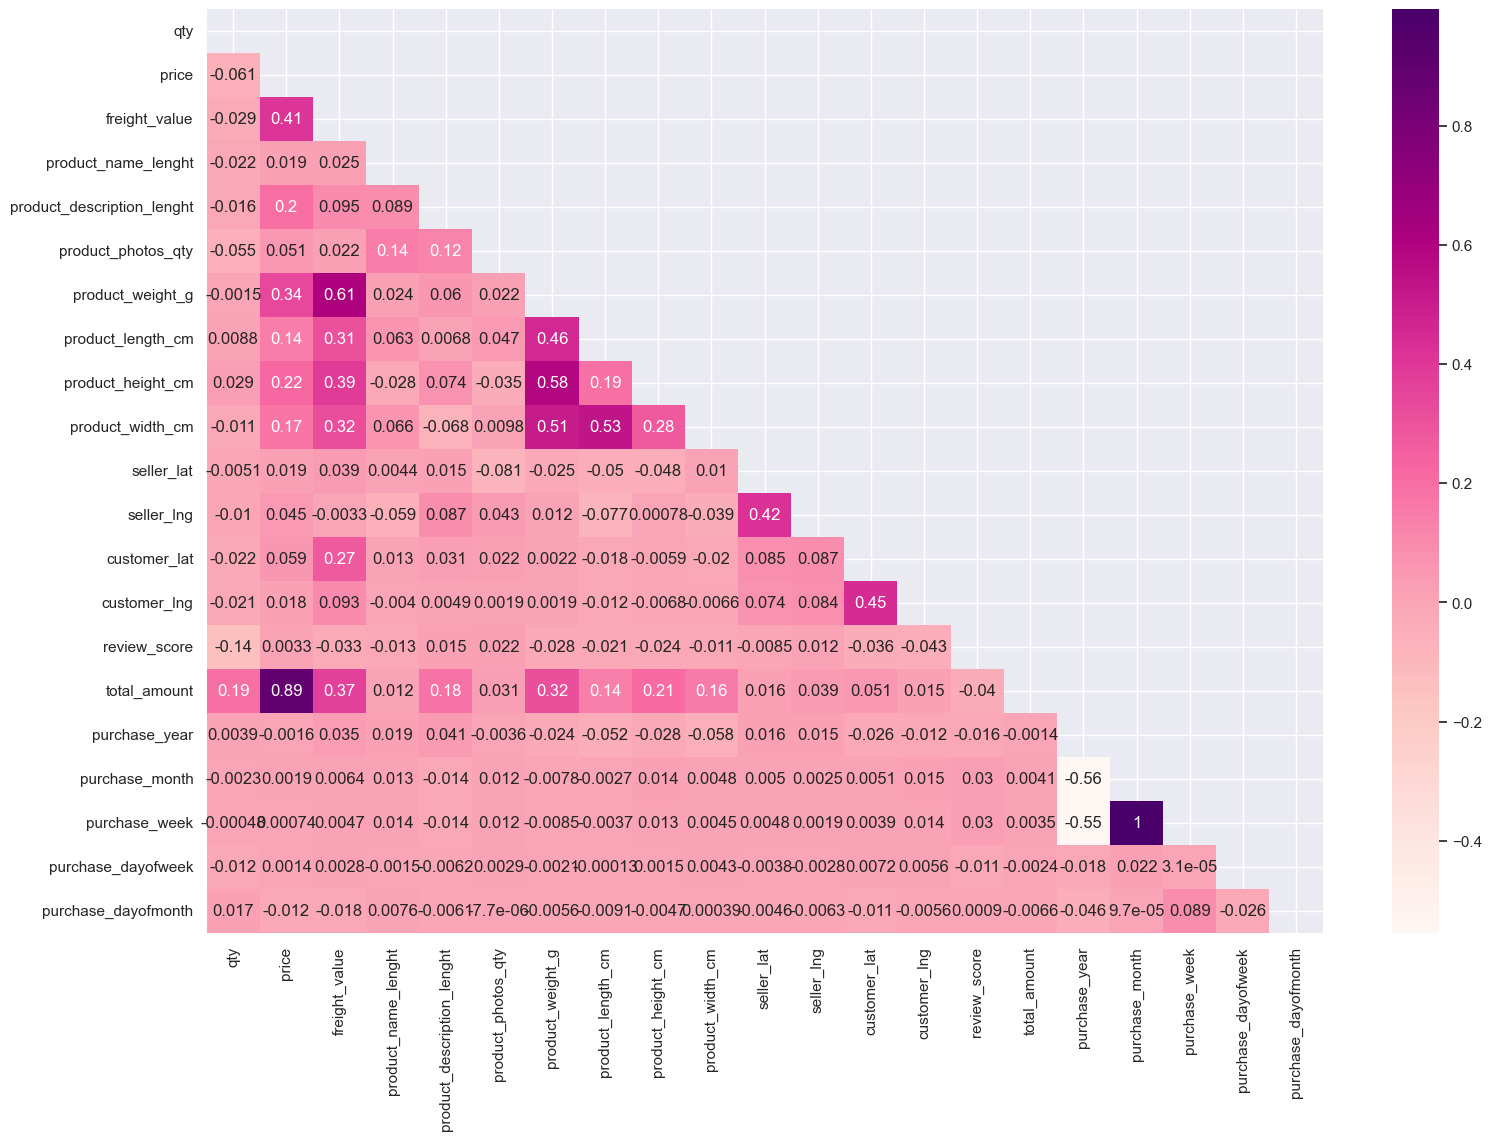

In [93]:
#canvas size
plt.figure(figsize=(18,12))
#correlation between all columns
corr_df= master.select_dtypes(include=np.number).corr()
# creating mask
mask = np.triu(np.ones_like(corr_df.corr()))
# plotting a triangle correlation heatmap
sns.heatmap(corr_df, cmap="RdPu", annot=True, mask=mask) 

#### Observation:

- We can see that total_amount is highly correlated with price. This is obvious because we know that total_amount was calculated using price.
- purchase_week and purchase_month are highly correlated.
- product_weight and freight values are positively correlated as frieght is calaculated as per product weight as it was specified by the data publishers on Kaggle.
- We don't see any other feature standing out to have high correlation with total_amount.

We will plot the histogram to see the distribution of total_amount.

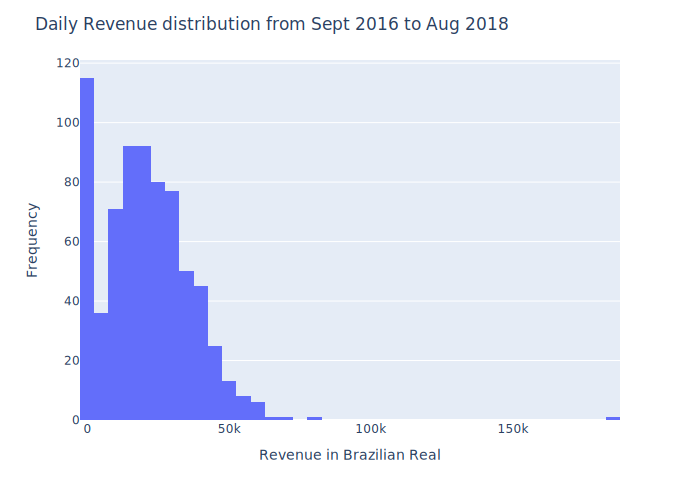

In [94]:
fig=px.histogram(df_agg, x='total_amount')
fig.update_layout(
    yaxis_title="Frequency",
    xaxis_title="Revenue in Brazilian Real",
    legend_title="", 
    title="Daily Revenue distribution from Sept 2016 to Aug 2018")
# fig.show()
fig.show("svg")

#### Observations:

- There is a peak at zero amount because we don't have any observation for most of the days in 2016.
- If we ignore that, our overall distribution is normal with some outliers at the right side. These outlier observations are from the peak sales time.

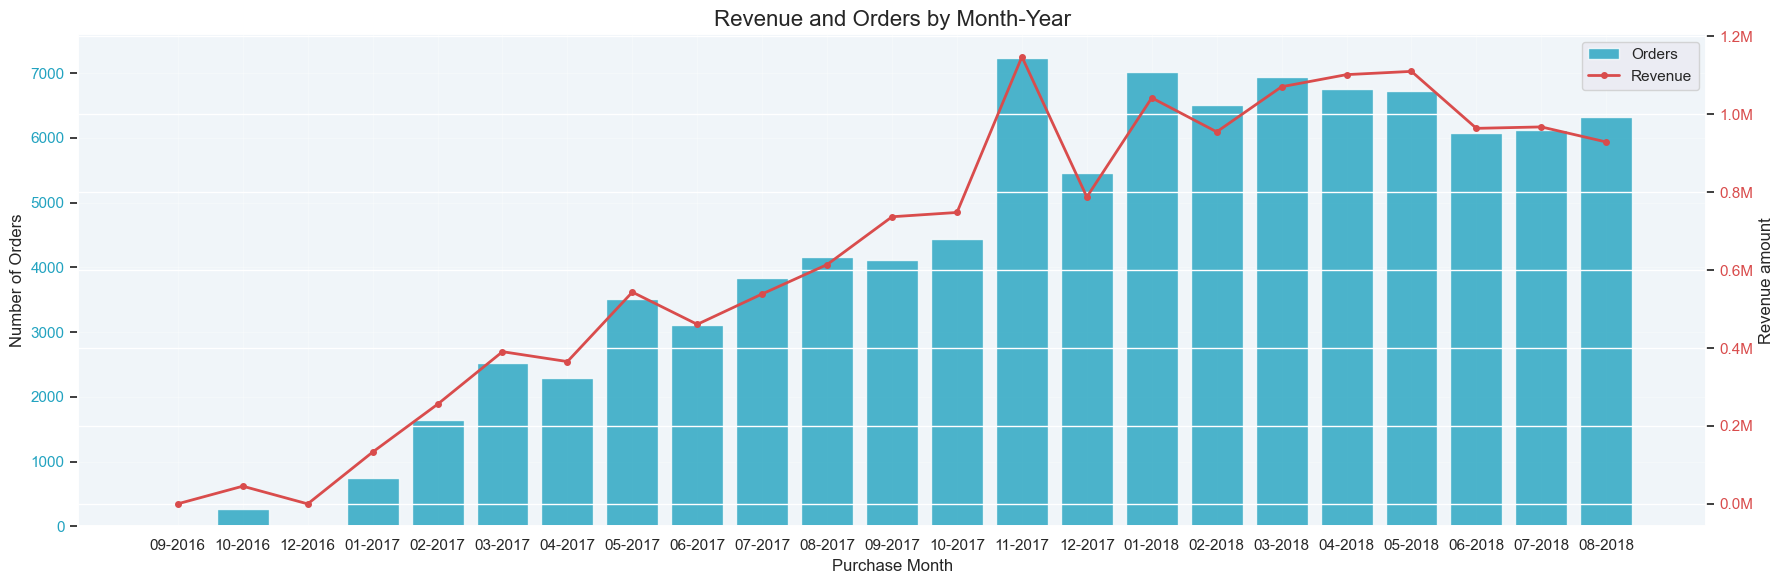

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Create the pivot table
sales_df = master.pivot_table(
    values=['order_id', 'total_amount'],
    index=['purchase_year', 'purchase_month', 'purchase_MMYYYY'],
    aggfunc={'order_id': 'nunique', 'total_amount': 'sum'}
)

# Reset index to make plotting easier
sales_df_reset = sales_df.reset_index()

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the bar chart for orders
bars = ax1.bar(sales_df_reset['purchase_MMYYYY'], 
               sales_df_reset['order_id'], 
               color='#22A3C0', 
               alpha=0.8)

# Format primary y-axis (orders)
ax1.set_ylabel('Number of Orders', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#22A3C0')
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for revenue
ax2 = ax1.twinx()
revenue_line = ax2.plot(sales_df_reset['purchase_MMYYYY'], 
                        sales_df_reset['total_amount'], 
                        color='#D94C4C', 
                        linewidth=2, 
                        marker='o', 
                        markersize=4)

# Format revenue y-axis with M formatter
def millions(x, pos):
    return f'{x/1000000:.1f}M'

ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.set_ylabel('Revenue amount', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#D94C4C')

# Set title and x-axis label
plt.title('Revenue and Orders by Month-Year', fontsize=16)
ax1.set_xlabel('Purchase Month', fontsize=12)

# Format x-axis labels
plt.xticks(rotation=90)

# Add faint background color
ax1.set_facecolor('#f0f5f9')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend([bars, revenue_line[0]], ['Orders', 'Revenue'], 
           loc='upper right', frameon=True)

# Adjust layout and display
plt.tight_layout()
plt.show()

We can see that both order made and total_amount are growing. There are some peaks that reappear after some month. The highes peak was recorded for Nov 2017. 

In [96]:

print(f"The overall revenue earned as of Aug 2018 is {df_agg.loc[:, 'total_amount'].sum()} Brazilian Real.")

The overall revenue earned as of Aug 2018 is 14909350.540000001 Brazilian Real.


We can check what is the overall revenue for each year and what is year over year growth from 2016 to 2017 and 2017 to 2018.

In [97]:
#checking the sale made in each year
df_agg.groupby(df_agg.index.year).sum()

,total_amount
order_purchase_timestamp,
2016,45756.84
2017,6722987.98
2018,8140605.72


In [98]:
print(f'The year over year growth from 2016 to 2017 is {6722987.98/45756.84 - 1}')

The year over year growth from 2016 to 2017 is 145.9285899113663


In [99]:
print(f'The year over year growth from 2017 to 2018 is {(8140605.72/6722987.98)-1}')

The year over year growth from 2017 to 2018 is 0.21086126350623036


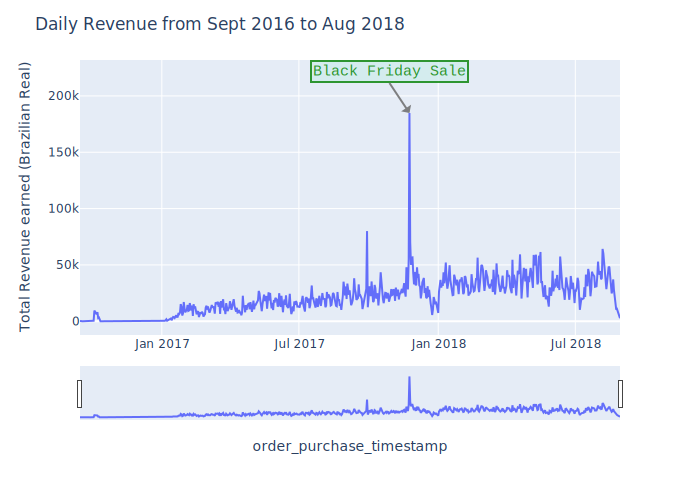

In [100]:
#plotting daily data to get high level picture

fig = px.line(df_agg, x=df_agg.index, y='total_amount')

# axis labels and title
fig.update_layout(
    yaxis_title="Total Revenue earned (Brazilian Real)", 
    legend_title="", 
    title="Daily Revenue from Sept 2016 to Aug 2018"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

#annotate peak
fig.add_annotation(x='2017-11-24', y= 184834.17, text=f'Black Friday Sale', yanchor='bottom', 
                   showarrow=True, arrowhead=1, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                   ax=-20, ay=-30, font=dict(size=15, color="green", family="Courier New, monospace"),
                   align="left", bordercolor="green", borderwidth=2, bgcolor="#CFECEC", opacity=0.8)

# fig.show()
fig.show("svg")

#### Observations:

- We can see that there is somewhat positive trend.
- There is almost zero sales after October 10 2016 till Jan 2017. There is a possibility that this data was captured for intial test phase.
- It looks like the business started rolling in from Jan 1 2017.
- There is a highest spike on Nov 24 2017 because it was black friday.
- There is another spike on Sept 29 2017 but I could not find the reason for it.
- Seasonality is not clear at this point.

#### Removing the observations before Jan 1 2017

Removing the data before Jan 01 2017 because there are a lot of consecutive days with zero sales. It may be because the period of Sept 2016 to Dec 2016 was an experimental phase. Including them in our model may impact our forecasting. We can find that we have continuous sales after Jan 2017.

In [101]:
df_agg.index = pd.to_datetime(df_agg.index)
daily_data = df_agg.loc[df_agg.index >= '2017-01-01', :]
# If you know which row number corresponds to Jan 1, 2017
cutoff_index = 42  # Replace with actual index position
daily_data = df_agg.iloc[cutoff_index:, :]

In [102]:
daily_data.tail()

,total_amount
order_purchase_timestamp,
2018-08-25,10891.40
2018-08-26,8526.19
2018-08-27,5542.90
2018-08-28,4088.37
2018-08-29,2670.54


In [103]:
print(f"The total number of datapoint to work on :{daily_data.shape[0]}")

The total number of datapoint to work on :672


`This is challenging now to work with limited data to forecast Sales.`

In [104]:
#saving the start and end dates separately
start_date=daily_data.index[0]
end_date=daily_data.index[-1]

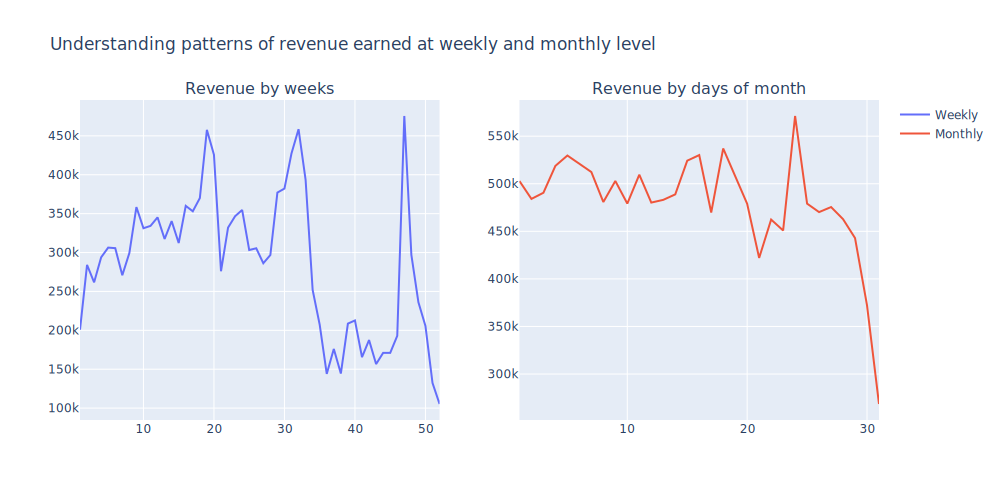

In [105]:
df1=master.groupby('purchase_week')['total_amount'].sum()
df2=master.groupby('purchase_dayofmonth')['total_amount'].sum()

fig=make_subplots(rows=1, cols=2, subplot_titles=("Revenue by weeks", "Revenue by days of month"))

fig.add_trace(go.Scatter(name='Weekly', x=df1.index, y=df1.values), row=1, col=1 )

fig.add_trace(go.Scatter(name='Monthly', x=df2.index, y=df2.values), row=1, col=2 )

fig.update_layout(height=500, width=1000,
                  title_text="Understanding patterns of revenue earned at weekly and monthly level")

# fig.show()
fig.show("svg")

Let us see which categories are highest earning categories.

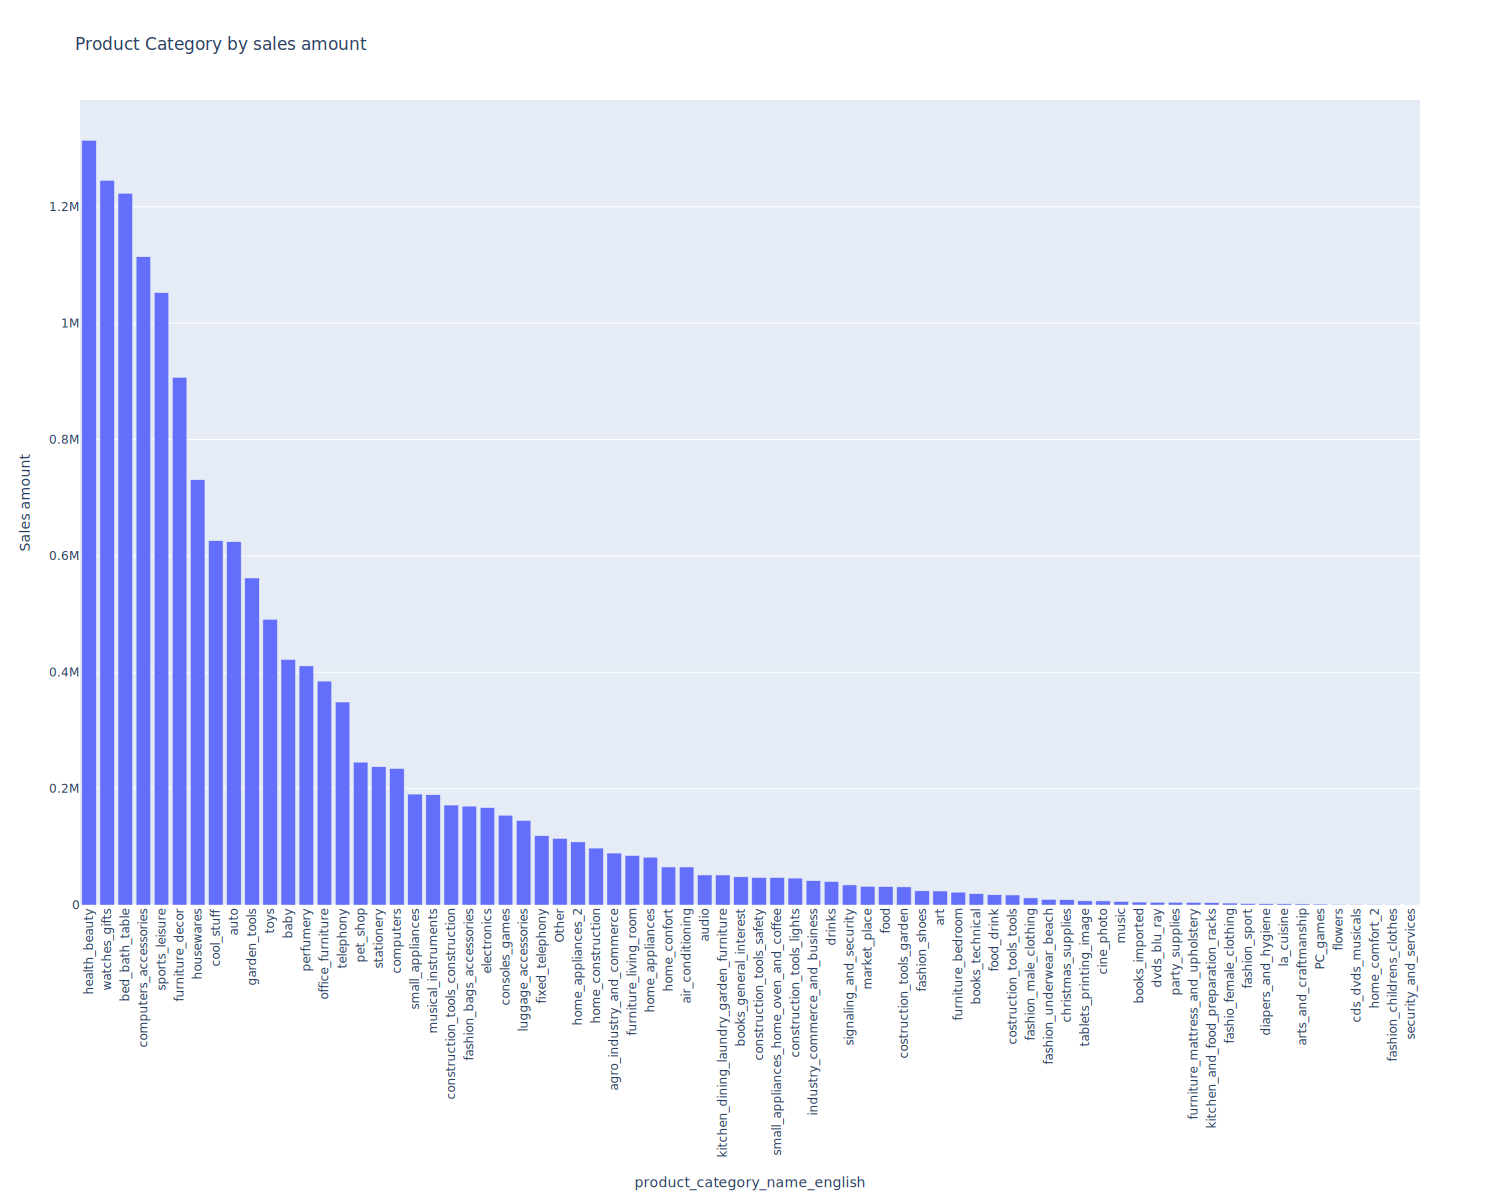

In [106]:
#the categories that are have highest sales amount
df=master.groupby('product_category_name_english')['total_amount'].sum().sort_values(ascending=False)
fig = px.bar(df, x= df.index,
             y=df.values,
             labels={'y':'Sales amount'},
             title='Product Category by sales amount',
             width=1500, height=1200      )
fig.update_xaxes(tickangle= -90) 
# fig.show()
fig.show("svg")

#### Observations:

- Health_beauty , watches_gift, bed_bath_table, computer_asscesories and sports_leisure are the top category by sales amount.
- PC_games, cds_dvds_musicals, fashion_children_clothes are the lowest earning products categories. 

## 3.2 Decomposing time series

<a id="Decomposing_time_series"></a>

**We will be decomposing the time series using additive decomposition so that we can observe the underlying trend, seasonality and residuals**. 

Additive Decomposition : $Trend$+$Seasonality$+$Residual$

In [107]:
# decompose the time series
decomposition = tsa.seasonal_decompose(daily_data, model='additive')

In [108]:
#saving copy to new datafrme
daily_df=daily_data.copy()

In [109]:
# add the decomposition data
daily_df['Trend'] = decomposition.trend
daily_df['Seasonal'] = decomposition.seasonal
daily_df['Residual'] = decomposition.resid

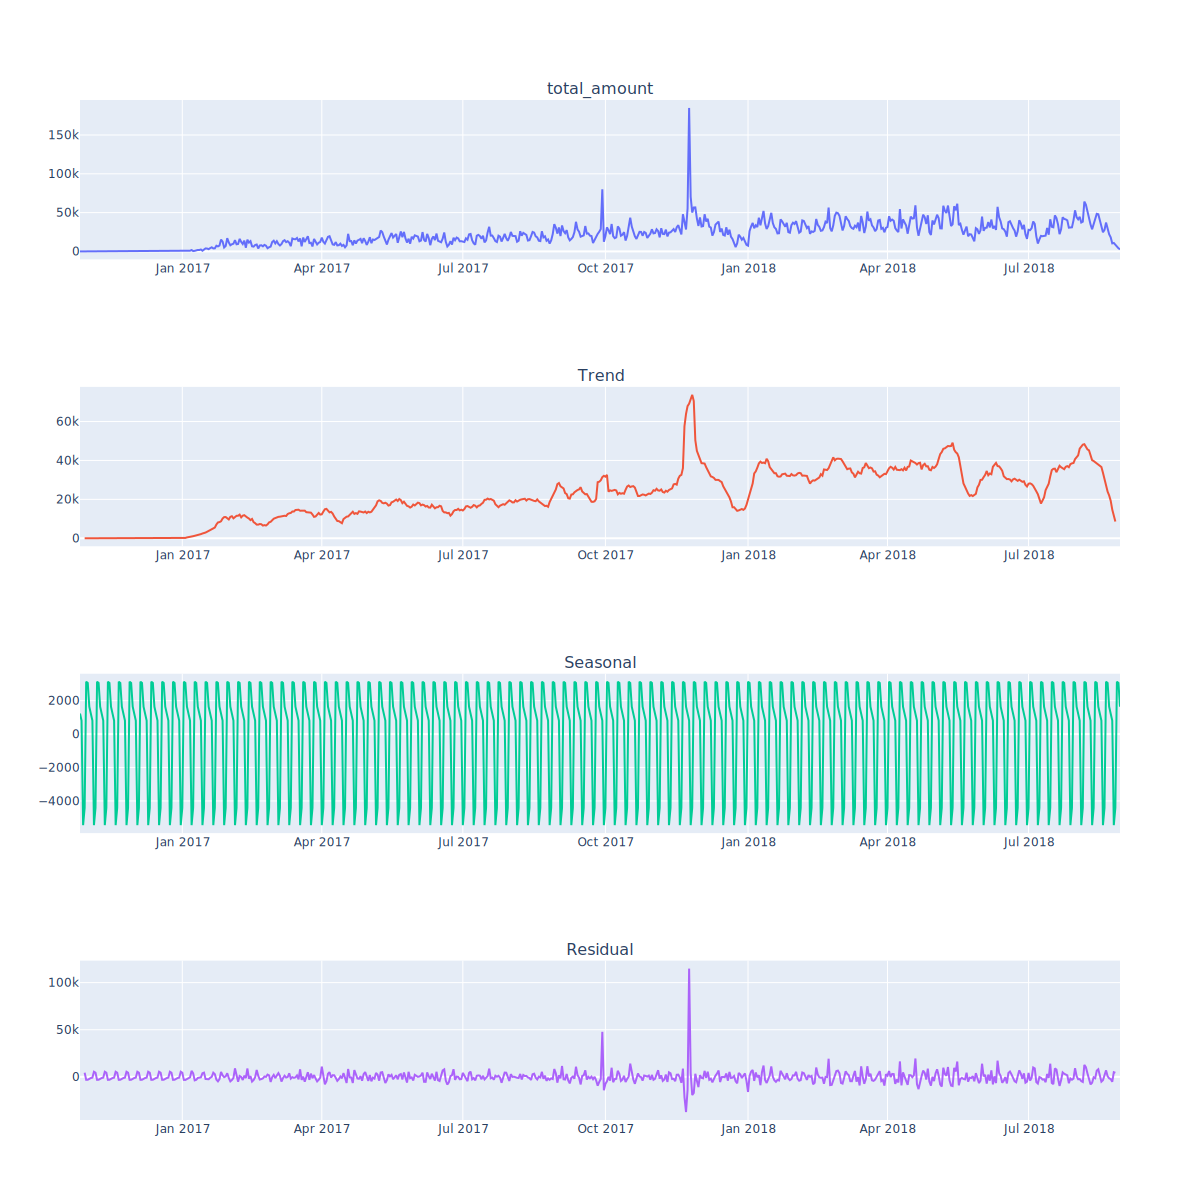

In [110]:
#plotting the actual and decomposed componenets of time series
cols = ["total_amount","Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=4, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_df.index, y=daily_df[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1200, width=1200, showlegend=False)
# fig.show()
fig.show("svg")

#### Observation:

- We can see that there is a slightly upward trend. Trend has a peak on Nov 26, 2017 beacuse of the black friday sale on Nov 24, 2017. It falls afterwards but then rises again. Although this black friday is an outlier but we should consider it in our calculatiobn as it is an important factor.
- There is a weekly seasonlality. It peaks once in the week and then falls. 
- There is no clear pattern in Residual. It has captured the peaks of Nov 24, 2017 and Sept 29, 2017.

<Axes: title={'center': 'Pattern of revenue earned at week level'}, xlabel='Weekday', ylabel='total_amount'>

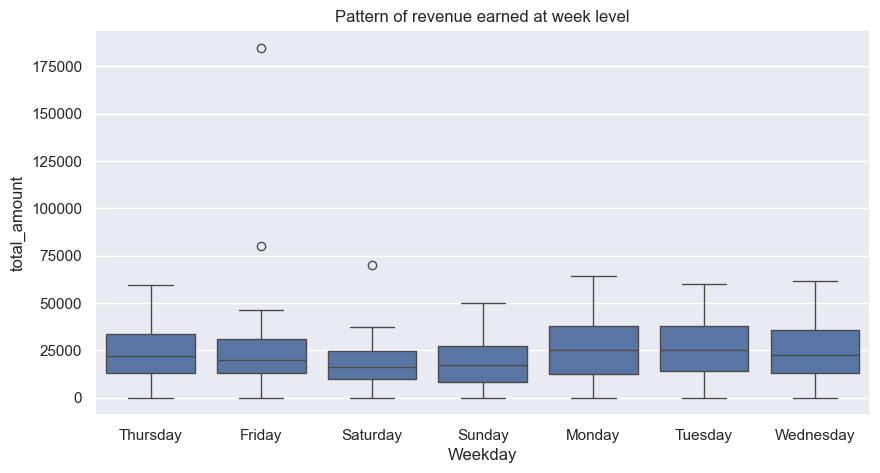

In [111]:
plt.subplots(figsize=(10,5))
# sns.set_theme(style= 'darkgrid' )
plt.title('Pattern of revenue earned at week level')
df_week_check=daily_data.copy()
df_week_check['Weekday']= df_week_check.index.weekday
week_day=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_week_check['Weekday']=df_week_check['Weekday'].apply(lambda x: week_day[x])          
sns.boxplot(data=df_week_check, x='Weekday', y='total_amount')

#### Observations:

- We can see that the amount earned is high on monday and tuesday. It decrease towards the end of week. 
- There are some outliers on Friday and Saturday because of the holidays.


We can now proceed ahead with the checking stationarity of the time series so that we can apply modelling.

#### Observations:

- We can see that the amount earned is high on monday and tuesday. It decrease towards the end of week. 
- There are some outliers on Friday and Saturday because of the holidays.


We can now proceed ahead with the checking stationarity of the time series so that we can apply modelling.

## 3.3 Checking stationarity

<a id="Checking_stationarity"></a>

Forecasting is bulit on assumption that historical data is representative of the future. It is important for a time series to be stationary, if it is not it means that that data changes over time and it will be hard to forecast that data.

If the mean and variance of the time series are constant that means the time series is sationary.
We will plot the rolling mean and rolling standard deviation for the time series to visually chacke for stationarity.
- A rolling average can help you find trends that would otherwise be hard to detect.
- Volatility is based on standard deviation, a measure of how much the data varies from the average - or the measure of spread.

[Reference](https://www.linkedin.com/pulse/qb4-bollinger-bands-rolling-mean-standard-deviation-alan-mcdowell/)

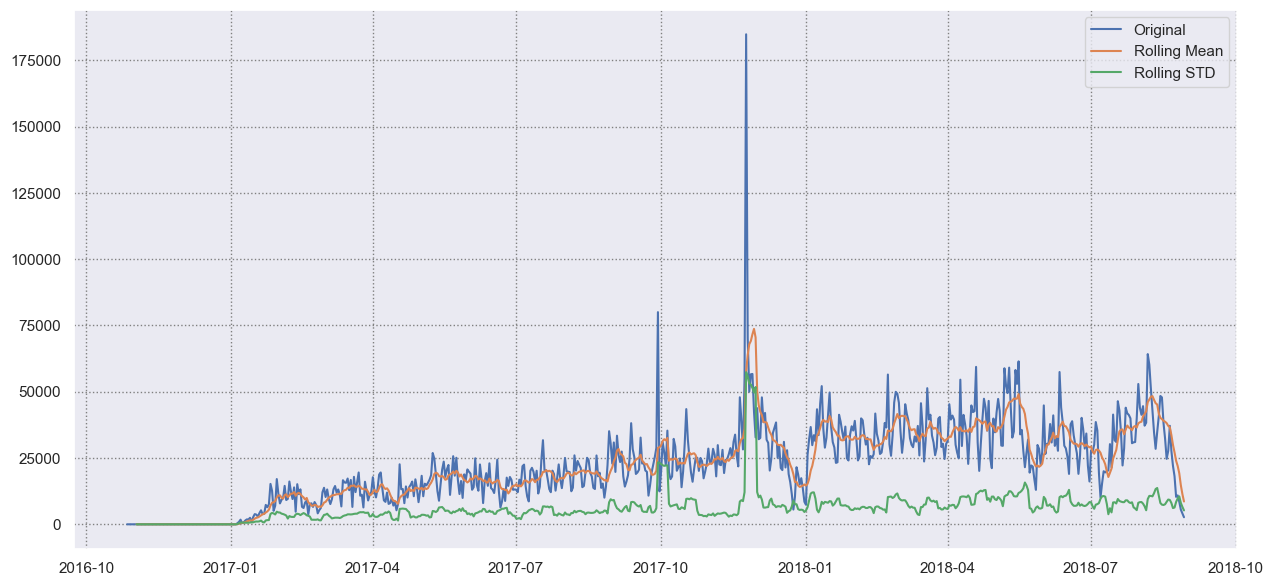

In [112]:
#plotting rolling mean and standard deviation.

# Get Things Rolling
roll_mean = daily_df['total_amount'].rolling(window=7).mean()
roll_std = daily_df['total_amount'].rolling(window=7).std()
    
# Figure
fig, ax = plt.subplots(figsize=(15,7), facecolor='w')
ax.plot(daily_df['total_amount'], label='Original')
ax.plot(roll_mean, label='Rolling Mean')
ax.plot(roll_std,  label='Rolling STD')
    
# Legend & Grid
ax.legend(loc='upper right')
plt.grid(linestyle=":", color='grey')
plt.show()

#### Observation:
- The mean is not constant. As we progress on time series the roling mean is having somewhat upward trend.
- There rolling mean rises and falls within two month period.
- Rolling standard deviation also doesn't look constant.
- Therefore, we can say that the trend is not stationary.

### Statistical tests to check stationarity

### ADF - Augmented Dickey Fuller Test

ADF test is used to determine the presence of unit root in the series, the presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary. The null and alternate hypothesis of this test are:

$H_0$ : The series has a unit root. 

$H_a$: The series has no unit root.

If the null hypothesis is failed to be rejected (the p-value obtained is greater than the significance level (say 0.05)), this test may provide evidence that the series is non-stationary.


### KPSS - Kwiatkowski-Phillips-Schmidt-Shin

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

$H_0$ : The process is trend stationary.

$H_a$: The series has a unit root (series is not stationary).

In [113]:
def perform_adf_test(df) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

#### ADF and KPSS test on original Sales amount

In [114]:
print("ADF and KPSS test on original total_amount")
print("******************************************")
perform_adf_test(daily_df['total_amount'])
perform_kpss_test(daily_df['total_amount'])

ADF and KPSS test on original total_amount
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -2.622708
p-value: 0.088394
Number of lags used: 13
Number of observations used: 658
T values corresponding to adfuller test:
1% -3.4403271946832645
5% -2.8659424728408456
10% -2.5691144817582985

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 3.155866
p-value: 0.010000
Number of lags used: 16
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


#### Observation and findings:

*ADF & KPSS Results on Original sales data*
- Since ADF Statistic  p-value: 0.006249 < 0.05 we can reject the $H_{0}$ hypothesis in the favor of $H_{a}$
- Since KPSS Statistic p_value: 0.01 < 0.05 we can reject the $H_{0}$ hypothesis in favour of $H_{a}$.

Based on these results we can conclude that:
- **According to ADF test our series have no unit root.** Thereby, inferring that the series is stationary.
- According to KPSS test our series is not trend-stationary.

Taking refrence from [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#Detrending-by-Differencing) which says if :  
**KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.**

We will proceed ahead with differencing the time series and recheck for stationarity.

#### Differencing the time series

We will try to difference the series by differencing it with a previous day observation. 

In [115]:
#differencing with previous day
daily_df["day_difference"] = daily_df["total_amount"].diff(1)

In [116]:
print("  ADF and KPSS test on differnced data  ")
print("******************************************")
perform_adf_test(daily_df["day_difference"].dropna())
perform_kpss_test(daily_df["day_difference"].dropna())

  ADF and KPSS test on differnced data  
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -9.949346
p-value: 0.000000
Number of lags used: 12
Number of observations used: 658
T values corresponding to adfuller test:
1% -3.4403271946832645
5% -2.8659424728408456
10% -2.5691144817582985

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.100292
p-value: 0.100000
Number of lags used: 30
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


#### Observations and findings:

*ADF & KPSS Results on differenced data*

- Since ADF Statistic  p-value: 0.000 < 0.05 we can reject the $H_{0}$ hypothesis in the favor of $H_{a}$
- Since KPSS Statistic p_value: 0.1 > 0.05 we cannot reject the $H_{0}$ hypothesis in favour of $H_{a}$.

Based on these results we can conclude that:
- **According to ADF test our series have no unit root.** Thereby, inferring that the series is stationary.
- According to KPSS test our series is not trend-stationary.

**Both tests conclude that - The series is stationary.**

We can proceed ahead with modelling.

# 4. Preparation for Modeling

<a id="Preparation_for_Modeling"></a>

We want to create some functions that we will call again and again. Hence we will be creating a test and tarin split 

## 4.1 Train and test split

<a id="Train_test_split"></a>

We will be splitting the series into train and test. We will not be splitting the train for a validation set as we have a limited number of data.

In [117]:
def train_test_split(df, train_end, test_set):
    """
    Splits input dataframe into test and train set with 80% / 20%.
    ---
    Args:
        df : dataframe to split with datetime index.
        train_end: end date of the train set (inclusive), it can be a datetime or string of format YYYY-MM-DD.
        test_end: end date of the test set

    Returns:
        train_df (pd.DataFrame): Train Dataframe
        test_df (pd.DataFrame):  Test Dataframe
    """
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set


train_end = '2018-4-30'
test_end = '2018-8-29'

train_df, test_df = train_test_split(daily_data, train_end, test_end)

In [118]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (551, 1) | 2016-10-27 00:00:00 to 2018-04-30 00:00:00
The Test data has time range :Shape (121, 1) | 2018-05-01 00:00:00 to 2018-08-29 00:00:00


## 4.2 Defining functions for plotting predictions and forecast

<a id="plotting_func"></a>

In [119]:
def plot_forecast(train_set, test_set, fc_series:pd.Series) -> None:
    """
    This function plots the train, test and forecast values.
    ---
    Args:
        train_df:  training dataframe with datetime index and only one column y
        test_df :  test dataframe with datetime index and only one column y
        fc_series: forecast series 
        
    Returns: None
    """
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_set.index, y=train_set.values, mode='lines', name="Train"))
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=fc_series.index, y=fc_series.values, mode='lines', name="Forecast"))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount", 
        xaxis_title="Date",
        title="Daily Sales amount and forecast"
    )
#     fig.show()
    fig.show("svg")


In [120]:
def plot_test_predictions(test_set, predictions) -> None:
    """
    This functions plots test set vs predicted values.
    ---
    Args:
        test_df : test dataframe with datetime index and only one column y
        predictions (predictions): prediction values (array or list)
    
    Returns: None
    """
    test_set=pd.Series(test_set, index= test_set.index)
    predictions=pd.Series(predictions, index= test_set.index)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values, mode='lines', name="Predictions"))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount for test and predicted values", 
        xaxis_title="Date",
        title="Daily revenue amount"
    )
#     fig.show()
    fig.show("svg")


## 4.3 Defining functions for evaluation

<a id="evaluation_metrics"></a>

Throughout this notebook we will be using these two function to evaluate the performance of our model. We will be defining functions to calculate MAPE and RMSE. If we have Y as actual value and Predictions as predicted value for n number of observations then:

MAPE (Mean Absolute Percentage Error): It is a simple average of absolute percentage errors. It is calculated by 

$$ \frac{1}{n} \sum_{i=1}^{n} {| \frac{Y_{actual_i} - Predictions_{i}}{Y_{actual_i}} |} \times{100} $$

RMSE (Root Mean Sqaured Error) : It is the square root of the average of the squared difference between the original and predicted values in the data set. 

$$ \sqrt{\frac{1}{n} \sum_{i=1}^{n} {{(Y_{actual_i} - Predictions_{i})}^2 }} $$

In [121]:
def mape_metrics(test_set, predicted) -> float:
    """
    This function calculates the MAPE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float MAPE percentage
    """
    # Calculate the MAPE value and return
    mape_result=round(np.mean(np.abs((test_set - predicted) / test_set)) * 100, 2)
    return mape_result

def rmse_metrics(test_set, predicted) -> float:
    """
    This function calculates the RMSE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float RMSE
    """  
    # Calculate the MAPE value and return
    return round(np.sqrt(np.mean((test_set - predicted)**2)),2)

# 5. Modelling (SARIMA)

<a id="SARIMA"></a>

We will start with SARIMA model to account for the seasonality in our model. SARIMA is Seasonal Autoregressive Integrated Moving Average, which explicitly supports univariate time series data with a seasonal component. Before jumping on to modelling, we need to get a basic understanding of what orders for Auto gregressive and Moving average to choose. We will plot the ACF and PACF plots to find it out.

ACF : Auto correlation function, describes correlation between original and lagged series.
PACF : Partial correlation function is same as ACF but it removes all intermediary effects of shorter lags, leaving only the direct effect visible.

## 5.1 Plotting ACF and PACF plot

<a id="ACF_PACF"></a>

In [122]:
def plot_acf_pacf(df, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title(f"Autocorrelation {df.name}", fontsize=15, pad=10)
    ax1.set_ylabel("Sales amount", fontsize=12)
    ax1.set_xlabel("Lags (Days)", fontsize=12)

    ax2.set_title(f"Partial Autocorrelation {df.name}", fontsize=15, pad=10)
    ax2.set_ylabel("Sales amount", fontsize=12)
    ax2.set_xlabel("Lags (Days)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

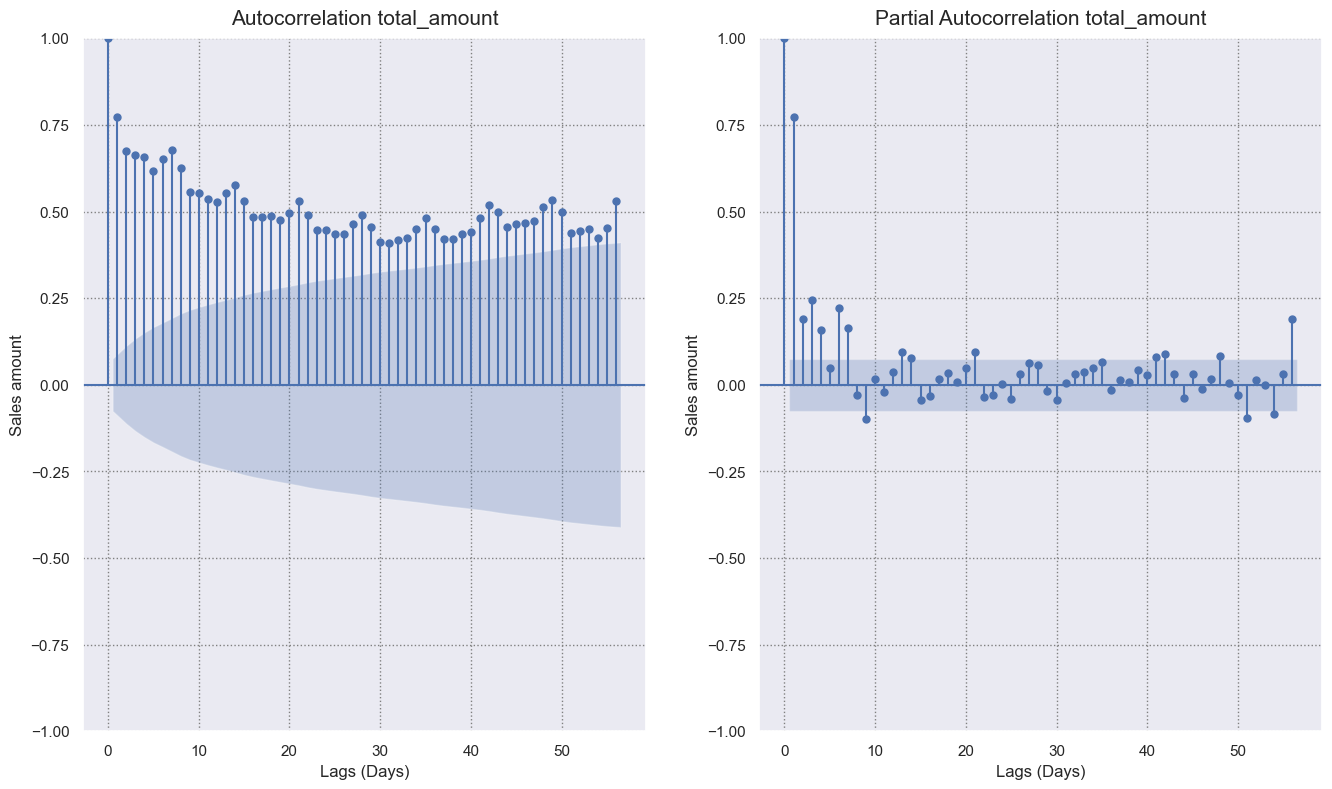

In [123]:
#plotting the ACF and PACF plot for original series
plot_acf_pacf(daily_df['total_amount'], acf_lags=56, pacf_lags= 56)

#### Observation:

ACF plot:
 - It shows that there are a lot of significant lags. *In ACF plot none of the lags are becoming zero.* **It means that our data is not stationary as we have explained using statistic test and observation of rolling mean and standard deviation.**
 - It will be hard to determing the AR and MA order, we will need to difference it so that we can identify some significant lags.
 - We can see that Lag peaks after evry 7 days. This is the seasonlity of the model.
    
PACF plot:
 - PACF model has a few significant lags but the plot is not decaying much and has a very little oscillation. So it is hard to say or identify if moving averages can be utilized on this model.
 
We will try to plot the ACF and PACF plot by double differncing means differencing the day_difference with seasonal differnce data.

In [124]:
#double differencing the column total_amount
daily_df['double_difference'] = daily_df['day_difference'].diff(7)

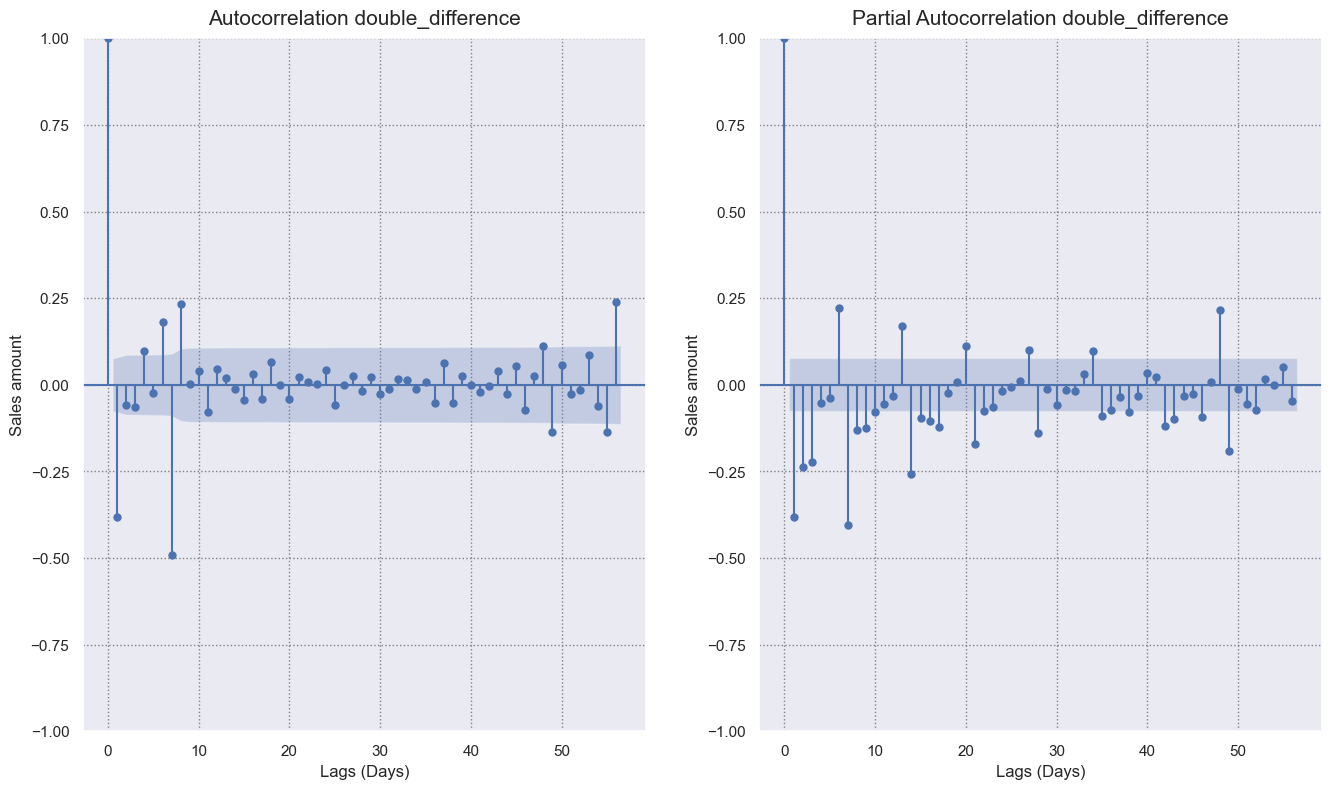

In [125]:
#plotting the ACF and PACF plot for double differenced series
plot_acf_pacf(daily_df['double_difference'].dropna(), acf_lags=56, pacf_lags= 56)

#### Observation:

It little difficult to tell, what values of  p and  q are appropriate for the data but we will try to find the appropriate orders.

ACF plot:
- A lot of lags have become zero now. There are few lags that are significant 1, 4, 6, 7 and 8. 
- We can use non seasonal MA of order 1, 4, 6 but the most significant lag is 1.
- The lag at 7 is also important and can help determing the seasonal MA component.

PACF plot:
- It shows signigicant peaks at every seasonal lag of 7 days and peaks are diminishing. Also the non-seasonal lags are also diminishing. So we can use seasonl and non-seasonal MA components in model. The MA components can be determined using the significant lags from ACF plot.
- Apart from seasonl lags, the lag of 1, 2 and 3 are also significant. We can one of these lags for our non-seasonl AR component. 

## 5.2 Applying SARIMA model  <a name="Baseline"></a>
---

The SARIMA model is specified 

$$SARIMA(p, d, q) \times (P, D, Q)_s$$

Where:
- Trend Elements are:
    - p: Autoregressive order
    - d: Difference order
    - q: Moving average order
- Seasonal Elements are:
    - P: Seasonal autoregressive order.
    - D: Seasonal difference order. D=1 would calculate a first order seasonal difference
    - Q: Seasonal moving average order. Q=1 would use a first order errors in the model
    - s: Single seasonal period

#### Theoretical estimates:
- **s**: In our PACF plot there is peak that reappears every 7 days. Thus, we can set seasonal period to **s = 7**. This also backed by our seasonal component after additive decomposition.
- **p**: We observed that there is some tappering in ACF plot and we found the significant lags of 1,2,3 from PACF plot. We can start with **p=1** and see how it works. 
- **d**: We observed that our series has some trend, so we can remove it by differencing, so **d = 1**.
- **q**: Based on our ACF correlations we can set **q = 1** since its the most significant lag. 
- **P**: **P = 0** as we are using ACF plot to find seasonl significant lag. 
- **D**: Since we are dealing with seasonality and we need to differnce the series, **D = 1**
- **Q**: The seasonal moving average will be set to **Q = 1** as we found only one significant seasonal lag in ACF plot. 
Here we go:

$$ SARIMA(1, 1, 1) \times (0, 1, 1)_{7} $$

### Baseline Sarima Model

In [126]:
# Set Hyper-parameters
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 1
s = 7

# Fit SARIMA
sarima_model = SARIMAX(train_df['total_amount'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      total_amount   No. Observations:                  551
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5705.795
Date:                           Thu, 20 Mar 2025   AIC                          11419.591
Time:                                   03:02:44   BIC                          11436.779
Sample:                               10-27-2016   HQIC                         11426.312
                                    - 04-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2622      0.039      6.773      0.000       0.186       0.338
ma.L1         -0.8491      0.028    -30.325

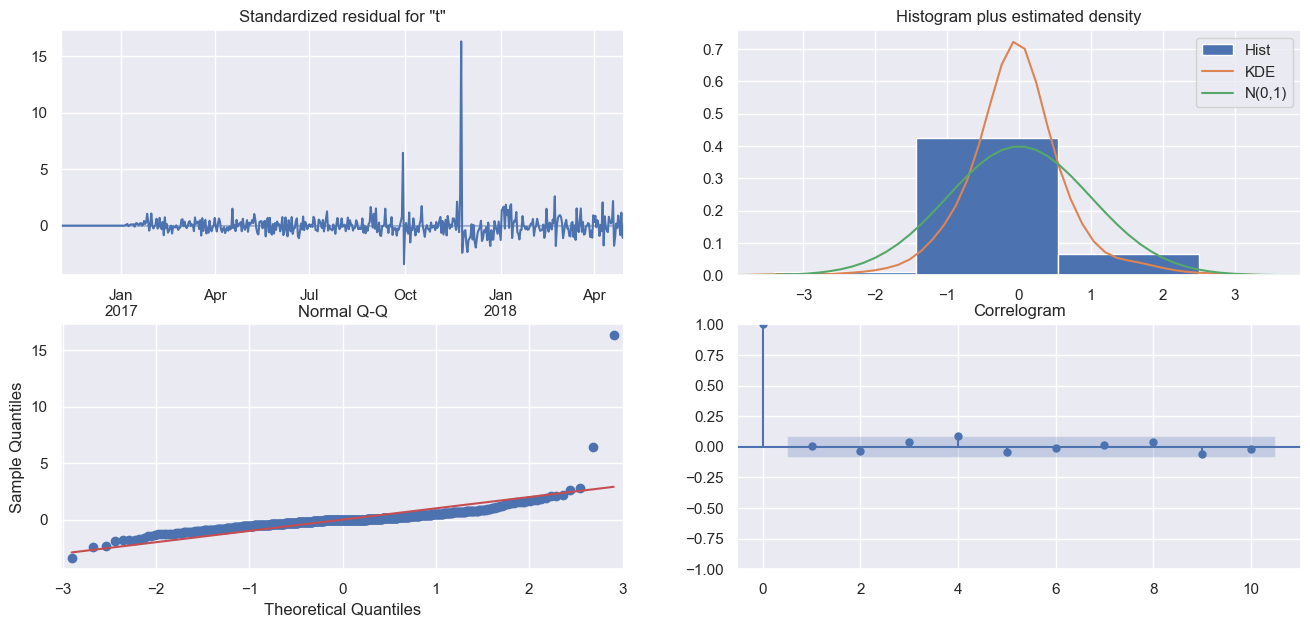

In [127]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(16,7))
plt.show()

#### Observations:
- **The standardize residual plot:**  The residuals appear as white noise. It looks like the residual of the decomposed time series.
- **The Normal Q-Q-plot:** Shows that the ordered distribution of residuals follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). There are some outlier as we have seen earlier.
- **Histogram and estimated density plot:**  The KDE follows the N(0,1) line however with noticeable differences. As mentioned before our distribution has heavier tails.
- **The Correlogram plot:** Shows that the time series residuals have low correlation with lagged versions of itself. Meaning there are no patterns left to extract in the residuals.

Lets test the model on our training set:

## 5.3 Plotting predictions and evaluating SARIMA model
<a id="plot"></a>

#### Prediction using SARIMA

In [128]:
# defining prediction period
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = test_df['total_amount'] - sarima_predictions

#### Evaluation of SARIMA

In [129]:
# Get evaluation data
sarima_root_mean_squared_error = rmse_metrics(test_df['total_amount'], sarima_predictions)
sarima_mape_error = mape_metrics(test_df['total_amount'], sarima_predictions)

print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error}')
print(f'Mean Absolute Percentage Error | MAPE: {sarima_mape_error}')

Root Mean Squared Error | RMSE: 13592.19
Mean Absolute Percentage Error | MAPE: 67.74


We are able to get a MAPE of 69.99 % and RMSE of 13810.6. 

#### Plotting test and prediction

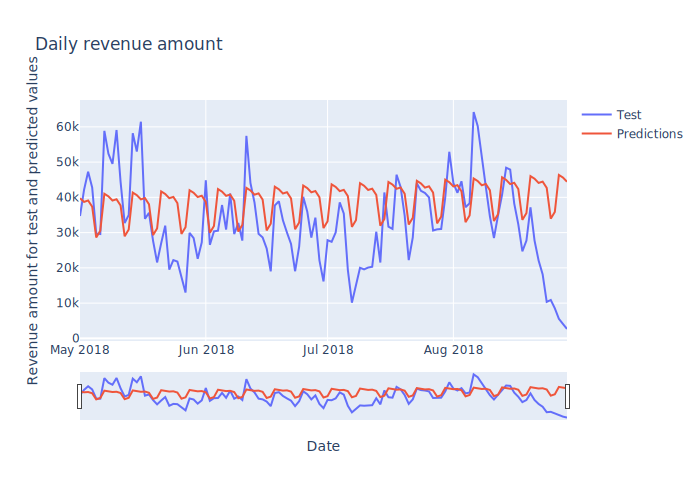

In [130]:
plot_test_predictions(test_df['total_amount'], sarima_predictions)

#### Observations:

Our baseline model is able to capture the seasonality and trend component but is not able to pick up the variations between weeks. The MAPE is also very high.

### Sarima Forecast

We will try to forecast the sales for next 180 days. We have the 121 days known from our test data and we will try to see what our model forcasts for next 60 days.

In [131]:
# Forecast Window
days = 180

sarima_forecast = sarima_model_fit.forecast(days)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negative orders are not possible we can trim them.
sarima_forecast_series[sarima_forecast_series < 0] = 0

#### Plotting Forecast using baseline SARIMA

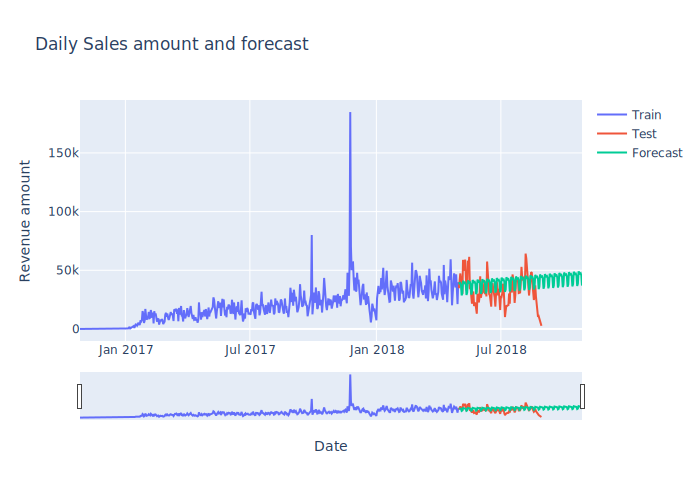

In [132]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], sarima_forecast_series)

#### Observations: 

- The model predicts the overall daily patterns pretty well. 
- Is not performning well to pick up the variation between weeks and months.
- It positively trending and is not capturing the peaks and toughs.
- We will need to tune it further and should also add another feature holiday so that it can pick some informations from that.
- While this model doesn't have a great long term predictive power it can serve as a solid baseline for our next models.

# 6. Modelling (Facebook Prophet)

<a id="FB_Prophet"></a>

FB Prophet is a forecasting package in Python that was developed by Facebook’s data science research team. The goal of the package is to give business users a powerful and easy-to-use tool to help forecast business results without needing to be an expert in time series analysis. We will apply this model and see how it performs.

## 6.1 Preparing data for FB Prophet

<a id="fb_prep"></a>

Faecbook prophet needs data in a certain format to be able to process it. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement here in our case it is total_amount.

In [133]:
#preparing the dataframe for fbProphet

prophet_df=df_agg['total_amount'].reset_index()
prophet_df.rename(columns={"index": "ds", "total_amount": "y"}, inplace=True)

#using our original train_df and test_df we will convert them into prophet train andt test set.
prophet_train = train_df["total_amount"].reset_index()
prophet_train.rename(columns={"order_purchase_timestamp": "ds", "total_amount": "y"}, inplace=True)
prophet_test = test_df["total_amount"].reset_index()
prophet_test.rename(columns={"order_purchase_timestamp": "ds", "total_amount": "y"}, inplace=True)

In [134]:
prophet_df.head()

,order_purchase_timestamp,y
0,2016-09-15,269.94
1,2016-09-16,0.00
2,2016-09-17,0.00
3,2016-09-18,0.00
4,2016-09-19,0.00


## 6.2 Applying a Baseline FB Prophet

<a id="fb_baseline"></a>

Since we observed that our data has positive trend and seasonality, we will set growth ='linear' and let the model find out appropriate seasonality by making yearly_seaonality, daily_seasonality and weekly_seasonality = True.

In [135]:
#instantiate the model
fb_baseline = Prophet(growth='linear', 
                yearly_seasonality=True, 
                daily_seasonality=True, 
                weekly_seasonality=True)
fb_baseline.fit(prophet_train)

03:02:45 - cmdstanpy - INFO - Chain [1] start processing
03:02:46 - cmdstanpy - INFO - Chain [1] done processing


#### Predictions using baseline Prophet

In [136]:
#make predictions dataframe 
future_base = fb_baseline.make_future_dataframe(periods=len(test_df), freq="D")

In [137]:
#make a forecast
forecast_base = fb_baseline.predict(future_base)
forecast_base[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
667,2018-08-25,33314.150060,21789.230634,44692.447658
668,2018-08-26,34096.401300,22966.891171,44886.306908
669,2018-08-27,40907.162163,29679.545928,52462.003343
670,2018-08-28,41196.833316,29760.505155,52920.284287
671,2018-08-29,40048.479555,29591.066151,51783.650194


In [138]:
forecast_base[-121:].reset_index()['yhat']


0      40091.034093
1      38846.509868
2      38940.219455
3      39411.742253
4      33511.454464
           ...     
116    33314.150060
117    34096.401300
118    40907.162163
119    41196.833316
120    40048.479555
Name: yhat, Length: 121, dtype: float64

## 6.3 Plotting and Evaluating Baseline model

<a id="fb_plot"></a>

In [139]:
#evaluating on test set
fb_baseline_mape = mape_metrics(prophet_test['y'], forecast_base[-121:].reset_index()['yhat'] )
fb_baseline_rmse = rmse_metrics(prophet_test['y'], forecast_base[-121:].reset_index()['yhat'] )

print(f'Root Mean Squared Error | RMSE: {fb_baseline_rmse}')
print(f'Mean Absolute Percentage Error | MAPE: {fb_baseline_mape}')

Root Mean Squared Error | RMSE: 12684.03
Mean Absolute Percentage Error | MAPE: 61.91


#### Plotting the forecast using Baseline FB Prophet

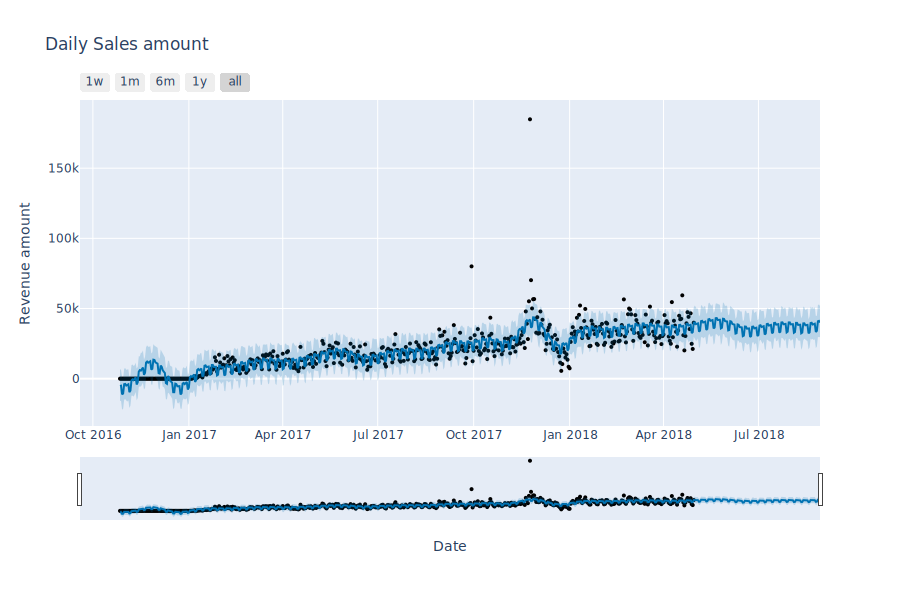

In [140]:
from prophet.plot import plot_plotly

fig = plot_plotly(fb_baseline, forecast_base) 
fig.update_layout(
    title="Daily Sales amount",
    xaxis_title="Date",
    yaxis_title="Revenue amount"
    )
# fig.show()
fig.show("svg")

#### Observations:

- Although the prophet didn't give us a good MAPE or RMSE yet form the plot we can see that it is able to capture seasonality, trend, some peaks and troughs.
- It is worth to explore futher by tuning the hyper parameters and include the holiday impact.

## 6.4 Tuning FB Prophet using Grid Search

<a id="fb_tuning"></a>

### Adding external variable Holiday

In [141]:
import pandas as pd

# 1) Définir le DataFrame des jours fériés
#    Ici, on utilise un exemple fictif avec une colonne "is_holiday" (0 ou 1)
#    et un index représentant des dates.
holiday_df = pd.DataFrame({
    'is_holiday': [0, 1, 0, 1],
}, index=["2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04"])

# 2) Construire un DataFrame "holiday_fb" pour Prophet
#    - 'holiday': nom du jour férié (ou catégorie)
#    - 'ds': date (au format datetime)
holiday_fb = pd.DataFrame({
    'holiday': 'Brazil holidays',
    'ds': pd.to_datetime(holiday_df.loc[holiday_df['is_holiday'] == 1].index)
})

# 3) Visualiser le résultat
print(holiday_fb)


           holiday         ds
0  Brazil holidays 2023-01-02
1  Brazil holidays 2023-01-04


#### Adding impact of holiday on our baseline

In [142]:
fb_baseline_holi = Prophet(growth='linear', 
                           holidays=holiday_df, 
                           yearly_seasonality=True, 
                           daily_seasonality=True, 
                           weekly_seasonality=True).add_country_holidays(country_name='BR')

fb_baseline_holi.fit(prophet_train)

ValueError: holidays must be a DataFrame with "ds" and "holiday" columns.

In [ ]:
#preparing forcast dataframe
future_base_holi = fb_baseline_holi.make_future_dataframe(periods=len(test_df), freq="D")

NameError: name 'fb_baseline_holi' is not defined

In [ ]:
#doing acrtual forecast
forecast_base_holi = fb_baseline_holi.predict(future_base_holi)
forecast_base_holi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

NameError: name 'fb_baseline_holi' is not defined

#### Evaluating the model on test data

In [ ]:
#evaluating on test set
fb_baseline_holi_mape=mape_metrics(prophet_test['y'], forecast_base_holi[-121:].reset_index()['yhat'] )
fb_baseline_holi_rmse=rmse_metrics(prophet_test['y'], forecast_base_holi[-121:].reset_index()['yhat'] )

print(f'Root Mean Squared Error | RMSE: {fb_baseline_holi_rmse}')
print(f'Mean Absolute Percentage Error | MAPE: {fb_baseline_holi_mape}')


NameError: name 'mape_metrics' is not defined

#### Observations: 

- Our baseline model actually became worse. We should tune the parameters to improve it.

# 7. Discussing issues encountered with hourly sampled data

<a id ="discussion"></a>

In an attempt to increase the data points, I tried to resample the dataset at hourly level and discovered that I got a lot of zero values at certain time of day because no order was placed during that time. I tried applying SAIMA model but it resulted in negative predictions and decreasing trend. Upon further reading and consulting, found that we will need to do some transfromations or apply differnt approaches to handle such data. Therfore, I limited myself to the daily data only. 

# 8.Conclusion 

<a id= "conclusion"></a>

Here is the summary of all the models we tested:
    
 ### Summary:

|Model|MAPE|
|----|----|
|SARIMA(1,1,1)(0,1,1)(7)|68.99 |
|Baseline Prophet|71.78|
|Baseline Prophet with holiday|77.88|

**We will be choosing the FB Prophet as the best performing model because it is able to achieve considerable MAPE.** 

In [ ]:
#saving the model as pickle file

import joblib

joblib.dump(fb_tuned, "forecasting_model.pkl")

NameError: name 'fb_tuned' is not defined